# INFO 2950 Project Phase II

Tina Chen (tc663), Catherine Fang (cf533), Vicki Chen (vc332)

## Research Questions

Kickstarter is a crowdfunding website that allows creators to make campaigns to fund startups, products, and projects to become a reality. These campaigns have many factors that can influnce how likely they are to successfully reach their targetted fundraising goal. These factors include category of the campaign, location the campaign is based in, and average amount donated by backers. My research question is examine the factors that lead to a campaign being successful, by measuring success of if they reached their targetted fundraising goal. The Kickstarter Dataset we are using has a combination of the publicly available information on past successful and unsuccessful kickstarter projects and data about the backers of each project. 

Research Question: Is there a relationship between the success of a Kickstarter campaign and factors relating its creation and release?
- What is the relationship between different categories and the success of a campaign? Which category has the highest success rate?
- How do kickstarter campaign success rates compare for US vs Non-US based projects?



## Data Description

The attributes (columns) of the dataset are the PID (Project ID), Category (numbers indicating what topic the project falls under), Subcategory (numbers indicating the subtopics within each category), the Project Location Name, State, County, and Country. Other relevant attributes included are the Project Currency, the Project’s Original Goal (how much money the creators were aiming for), amount of money pledged, the number of backers, the launched date, deadline date, and state. State is defined as either suspended (funding for a project is stopped when the project violates Kickstarter’s rules), canceled (the creators of a project dropped the project themselves), failed (the project didn’t meet funding goals), and successful (project meets funding goals). Each observation (row) corresponds to one unique project, indexed with a CaseID.

The raw dataset was created by Jonathan Leland, Kickstarter’s Head of Insights for a cross-sectional study on the different creative projects that seek crowdfunding. He created the dataset to observe data on the projects from Kickstarter. The creation of this dataset is funded by Kickstarter Data, the company crowdfunding platform that directs the Kickstarter Project. The study is distributed through the Inter-University Consortium for Political and Social Research (ICPSR). 

Some columns were be presented as optional for users to fill out, so in the raw data there are some rows with missing values. For example, for the PROJECT_LOCATION_STATE, PROJECT_LOCATION_COUNTY, PROJECT_LOCATION_COUNTRY column, there are some missing data values. But there are no missing values in the PROJECT_LOCATION_NAME, meaning that the project creators were required to put down the location name for their project. Several restrictions were placed on the data before releasing it for public use. The names of the people/groups who created past Kickstarter projects (NAME) and the links to their projects’ websites (URL_NAME), and the descriptions of their projects (BLURB) are not shown in the public data set that was used as the raw dataset for this project. This ensures anonymity of survey participants and prevents disclosure risk from survey participants.

Raw Data was collected by downloading the delimited data from the study at this link, https://www.icpsr.umich.edu/web/ICPSR/studies/38050/summary and Git Large Language Storage was used to upload the raw files onto Github. 

## Data Cleaning

Data cleaning was done to create a dataset from the raw data for analysis. After opening the original public_data tsv file, we observed that several variables were not available publicly and were only available in the restricted dataset which we did not have access to. These variables include NAME, URL_NAME, and PROJECT_PAGE_LOCATION_COUNTRY. In addition, there were some rows that had missing values, particularly in the PROJECT_PAGE_LOCATION_STATE, and PROJECT_PAGE_LOCATION_COUNTY columns which may indicate that these are user-inputs that are optional. These columns were dropped.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression 
import seaborn as sns
import duckdb
import datetime
##import timedelta

We imported the data and printed out the first 5 rows to view the columns provided by the dataset.

In [2]:
public_data = pd.read_csv('data/public_data.tsv', delimiter='\t')
public_data.head()

C:\Users\lovet\AppData\Local\Temp\ipykernel_9280\4156237419.py:1: DtypeWarning: Columns (9,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  public_data = pd.read_csv('data/public_data.tsv', delimiter='\t')


,CASEID,NAME,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_PAGE_LOCATION_STATE,PROJECT_PAGE_LOCATION_COUNTY,PROJECT_PAGE_LOCATION_COUNTRY,UID,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE,URL_NAME
0,1,MASKED BY ICPSR,2137925650,11,301,London,England,Greater London,,1076478145,USD,"100,000,000",0,"$100,000,000",$0,0,8/11/2016,10/10/2016,canceled,MASKED BY ICPSR
1,2,MASKED BY ICPSR,1501531085,11,296,Los Angeles,CA,Los Angeles,,224946798,USD,"100,000,000",85,"$100,000,000",$85,4,12/19/2019,2/14/2020,canceled,MASKED BY ICPSR
2,3,MASKED BY ICPSR,953415668,16,51,Mexico,Baja California,Tijuana,,1772203542,MXN,"100,000,000",10,"$5,219,374",$1,1,3/1/2017,3/22/2017,failed,MASKED BY ICPSR
3,4,MASKED BY ICPSR,1371386304,18,18,Columbus,OH,Franklin,,1373465389,USD,"100,000,000",1,"$100,000,000",$1,1,6/4/2018,7/5/2018,canceled,MASKED BY ICPSR
4,5,MASKED BY ICPSR,1720842777,1,22,Toronto,ON,Toronto,,1455666383,CAD,"100,000,000",0,"$80,610,122",$0,0,5/1/2015,6/30/2015,failed,MASKED BY ICPSR


We checked for duplicates in the public_data.tsv dataset by selecting the rows that appeared more than once according to the unique PID. Since there are no rows that appeared more than once, we know that there is no duplicate PIDs in the dataset.

In [3]:
duckdb.sql("SELECT PID, COUNT(PID) FROM public_data GROUP BY PID HAVING COUNT(PID) > 1").df()

,PID,count(PID)


We dropped the following columns: NAME, PROJECT_PAGE_LOCATION_COUNTRY, and URL_NAME since they contained restricted information that wasn't available to the public. We also dropped the PROJECT_PAGE_LOCATION_STATE and PROJECT_PAGE_LOCATION_COUNTY since they were prone to user-input error and it is not plausible to clean all 600,000+ entries manually.

We also dropped the UID, and the rows that are not successful or failed (canceled or suspended). By definition, a canceled project is one that the project leader has stopped voluntarily and a suspended project is one that was taken down by KickStarter moderators for violating their terms of service or other policies. 

In [4]:
public_data_df = pd.DataFrame(public_data)
clean_data = public_data_df.drop(columns = ["NAME", "PROJECT_PAGE_LOCATION_COUNTRY", "URL_NAME", "UID", "PROJECT_PAGE_LOCATION_STATE", "PROJECT_PAGE_LOCATION_COUNTY"])

clean_data = duckdb.sql("SELECT * FROM clean_data WHERE STATE = 'successful' OR STATE = 'failed'").df()
clean_data.head()

,CASEID,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE
0,56,128197700,12,35,Osaka,JPY,"68,000,000","81,030,744","$623,968","$743,538",12613,3/26/2018,5/5/2018,successful
1,63,1900597540,12,35,Tokyo,JPY,"53,808,516","481,621,841","$510,735","$4,571,420",46307,7/27/2020,8/29/2020,successful
2,83,1012629901,12,35,Ishikawa,JPY,"45,000,000","98,863,825","$414,327","$910,266",8051,6/3/2019,6/11/2019,successful
3,175,596722349,12,35,Chiba-shi,JPY,"16,665,000","23,606,140","$148,285","$210,047",1705,9/20/2018,10/20/2018,successful
4,184,2056420743,16,337,Tokyo,JPY,"15,000,000","17,406,300","$133,229","$154,601",656,10/7/2017,12/6/2017,successful


We also changed all the numerical string values in the dataframe into integers for us to work with. 

In [13]:
clean_data["GOAL_IN_ORIGINAL_CURRENCY"] = clean_data["GOAL_IN_ORIGINAL_CURRENCY"].replace({',': ''}, regex=True).astype(int)
clean_data["PLEDGED_IN_ORIGINAL_CURRENCY"] = clean_data["PLEDGED_IN_ORIGINAL_CURRENCY"].replace({',': ''}, regex=True).astype(int)
clean_data["GOAL_IN_USD"] = clean_data["GOAL_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
clean_data["PLEDGED_IN_USD"] = clean_data["PLEDGED_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
clean_data.head()

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
C:\Users\lovet\AppData\Local\Temp\ipykernel_9280\1737847697.py:3: SyntaxWarning: invalid escape sequence '\$'
  clean_data["GOAL_IN_USD"] = clean_data["GOAL_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
C:\Users\lovet\AppData\Local\Temp\ipykernel_9280\1737847697.py:4: SyntaxWarning: invalid escape sequence '\$'
  clean_data["PLEDGED_IN_USD"] = clean_data["PLEDGED_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
C:\Users\lovet\AppData\Local\Temp\ipykernel_9280\1737847697.py:3: SyntaxWarning: invalid escape sequence '\$'
  clean_data["GOAL_IN_USD"] = clean_data["GOAL_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
C:\Users\lovet\AppData\Local\Temp\ipykernel_9280\1737847697.py:4: SyntaxWarning: invalid escape sequence '\$'
  clean_data["PLEDGED_IN

ValueError: invalid literal for int() with base 10: ' '

We converted the BACKERS_COUNT column into integer values. 

DID NOT RUN YET, IN PROGRESS:

We also checked for oddities and outliers. For instance, we found rows where the BACKERS_COUNT variable was Null so we cross examined what values the identified rows' PLEDGED_IN_ORIGINAL_CURRENCY columns had to see if the value was 0 or was not 0. If it was 0, then we replaced the NaaN values with 0 since we can assume the number of backers is 0 since no money was pledged by no people. 

*** Need to decide what to do with the NaN values that have non-zero values in their PLEDGED_IN_ORIGINAL_CURRENCY column.

In [6]:
# # clean_data = duckdb.sql("SELECT * FROM clean_data WHERE BACKERS_COUNT IS NOT NULL'").df()
print(clean_data['BACKERS_COUNT'].dtype)

clean_data = duckdb.sql("""
SELECT *,
    CASE 
        WHEN isnan('BACKERS_COUNT') OR 'BACKERS_COUNT' IS NULL 
        THEN 0 
        ELSE 'BACKERS_COUNT'
    END AS 'BACKERS_COUNT'
FROM clean_data""").df()

# # # AND PLEDGED_IN_ORIGINAL_CURRENCY > 0


object


BinderException: Binder Error: Could not choose a best candidate function for the function call "isnan(STRING_LITERAL)". In order to select one, please add explicit type casts.
	Candidate functions:
	isnan(DOUBLE) -> BOOLEAN
	isnan(FLOAT) -> BOOLEAN


We used the datetime package to calculate the amount of time in days that each project fundraiser ran for. 

We plan to use that length of time to see if there is a relationship between LAUNCHED_DATE and DEADLINE_DATE and the rate of success of the project.

We calculated the time difference and added it as a new column to the clean_data and then dropped the LAUNCHED_DATE and DEADLINE_DATE columns.

In [7]:
clean_data['LAUNCHED_DATE'] = pd.to_datetime(clean_data['LAUNCHED_DATE'], format = 'mixed')
clean_data['DEADLINE_DATE'] = pd.to_datetime(clean_data['DEADLINE_DATE'], format = 'mixed')

clean_data['time_difference'] = (clean_data['DEADLINE_DATE'] - clean_data['LAUNCHED_DATE']).dt.days
clean_data = clean_data.drop(columns = ["LAUNCHED_DATE", "DEADLINE_DATE"])
clean_data.head()


,CASEID,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,STATE,time_difference
0,56,128197700,12,35,Osaka,JPY,68000000,81030744,623968,743538,12613,successful,40
1,63,1900597540,12,35,Tokyo,JPY,53808516,481621841,510735,4571420,46307,successful,33
2,83,1012629901,12,35,Ishikawa,JPY,45000000,98863825,414327,910266,8051,successful,8
3,175,596722349,12,35,Chiba-shi,JPY,16665000,23606140,148285,210047,1705,successful,30
4,184,2056420743,16,337,Tokyo,JPY,15000000,17406300,133229,154601,656,successful,60


Maybe also look at when STATE is canceled or failed in the future and maybe do a multivariable regression with the previously calculated time_difference (which represents the length of the fundraiser)

We now decided we should split the data into two dataframes based on PROJECT_CURRENCY, one that contains projects that used USD as its original currency and the other that contains projects that used Non-USD currencies as its original currency. 

In [8]:
us_currency = duckdb.sql("SELECT * FROM clean_data WHERE PROJECT_CURRENCY = 'USD'").df()
non_us_currency = duckdb.sql("SELECT * FROM clean_data WHERE NOT PROJECT_CURRENCY = 'USD'").df()
# print(us_currency.size)
# print(non_us_currency.size)

,CASEID,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,STATE,time_difference
0,985,1454565733,11,303,Minneapolis,USD,2000000,5764229,2000000,5764229,48270,successful,32
1,992,947809001,12,35,Tokyo,USD,2000000,6333295,2000000,6333296,69320,successful,32
2,1089,1755266685,11,31,San Diego,USD,2000000,5702153,2000000,5702153,91585,successful,31
3,1113,1871494789,11,31,Los Angeles,USD,2000000,3105473,2000000,3105473,46520,successful,30
4,1131,1682353635,12,35,Fairfax,USD,2000000,2232933,2000000,2232933,14873,successful,30


## Exploratory Data Analysis

We split the projects based on successful and failed campaign projects as we wanted to analyze the relationship between specific factors for successful projects compared to failed projects.

In [10]:
success_proj = duckdb.sql("SELECT * FROM clean_data WHERE STATE ='successful'").df()
failed_proj = duckdb.sql("SELECT * FROM clean_data WHERE STATE ='failed'").df()

We wanted to determine the median of the data to compare campaign projects by those that are above the median in campagin goal and those that are below the median, and separated the data as such.

In [11]:
success_data_above_med = duckdb.sql("SELECT * FROM success_proj GROUP BY * HAVING GOAL_IN_USD >= median(GOAL_IN_USD) ").df()
success_data_below_med = duckdb.sql("SELECT * FROM success_proj GROUP BY * HAVING GOAL_IN_USD < median(GOAL_IN_USD) ").df()
failed_data_above_med = duckdb.sql("SELECT * FROM failed_proj GROUP BY * HAVING GOAL_IN_USD >= median(GOAL_IN_USD) ").df()
failed_data_below_med = duckdb.sql("SELECT * FROM failed_proj GROUP BY * HAVING GOAL_IN_USD < median(GOAL_IN_USD) ").df()

We want to visualize the relationship between the number of backers and the campaign goal for successful projects. 

TypeError: arange() not supported for inputs with DType <class 'numpy.dtypes.StrDType'>.

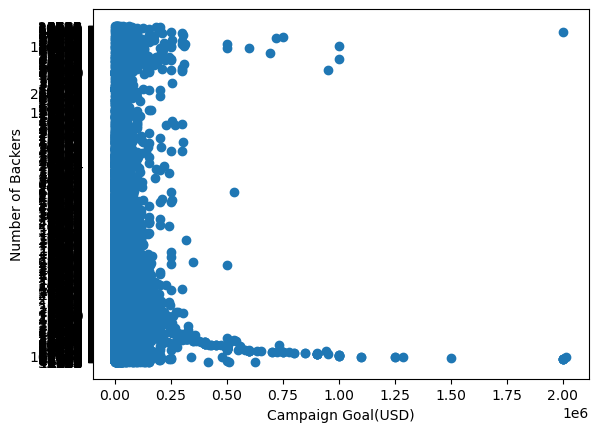

In [12]:
plt.scatter(success_proj["GOAL_IN_USD"], success_proj["BACKERS_COUNT"])
plt.xlabel("Campaign Goal(USD)")
plt.ylabel("Number of Backers")
plt.yticks(np.arange(0,max(success_proj["BACKERS_COUNT"]), step=15000))
plt.show()

We analyze the relationship between categories and the project's Campaign Goals (in USD) for all successful projects. 

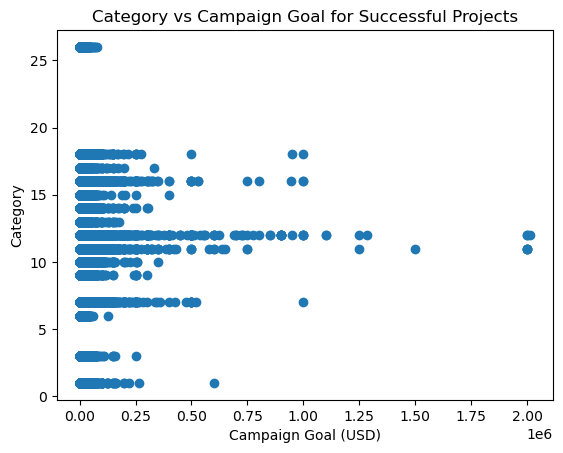

In [47]:
plt.scatter(success_proj["GOAL_IN_USD"], success_proj["CATEGORY"])
plt.xlabel("Campaign Goal (USD)")
plt.ylabel("Category")
plt.title("Category vs Campaign Goal for Successful Projects")
plt.show()

We then created a new dataframe named 'currency_success_df' to better understand the project's currency, number of successful projects for each respective currency, the total number of projects for each respective currency, to calculate the success rate for projects of each respective currency.

We also calculated the total number of different currencies there are which was 15. We also calculated the average success rate across all currencies. 

In [48]:
currency_success_df = duckdb.sql("""
SELECT 
    PROJECT_CURRENCY AS project_currency,
    SUM(CASE WHEN STATE = 'successful' THEN 1 END) AS num_successful,
    COUNT(*) AS total_projects,
    CASE 
        WHEN COUNT(*) = 0 THEN 0
        ELSE COUNT(CASE WHEN STATE = 'successful' THEN 1 END) * 1.0 / COUNT(*)
    END AS success_rate
FROM 
    clean_data 
GROUP BY 
    PROJECT_CURRENCY
ORDER BY num_successful DESC
""").df()

num_diff_currencies = len(currency_success_df)
print(num_diff_currencies)

avg_success_rate = currency_success_df['success_rate'].mean()
print(f"The average success rate of all currencies is {avg_success_rate:.2f}")

currency_success_df.iloc[:]

15
The average success rate of all currencies is 0.46


,project_currency,num_successful,total_projects,success_rate
0,USD,178334.0,381291,0.467711
1,GBP,28143.0,55269,0.509200
2,EUR,17256.0,41495,0.415857
3,CAD,10908.0,23890,0.456593
4,AUD,5162.0,12354,0.417840
5,HKD,3038.0,4350,0.698391
6,MXN,2204.0,6379,0.345509
7,SEK,1354.0,3139,0.431348
8,JPY,1289.0,2023,0.637173
9,SGD,1213.0,2331,0.520378


We analyze the relationship between categories and the project's Campaign Goals (in USD) for failed projects. 

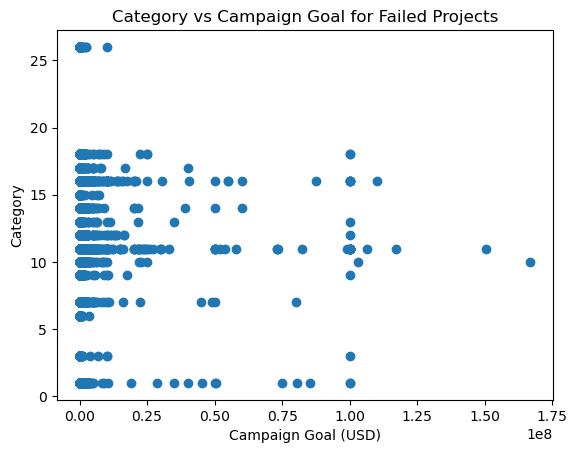

In [49]:
plt.scatter(failed_proj["GOAL_IN_USD"], failed_proj["CATEGORY"])
plt.xlabel("Campaign Goal (USD)")
plt.ylabel("Category")
plt.title("Category vs Campaign Goal for Failed Projects")
plt.show()

We then made the categorical variable, STATE, into a binary variable so we can run logit on it with other variables later to find possible predictors for the success and/or failure of a project.

We plan to make another column that indicates the rate of success or failure that may be predicted by a specific variable, using a GROUP BY statement.

In [ ]:
clean_data["STATE"] = pd.get_dummies(clean_data["STATE"], dtype=int, drop_first=True)

We run a logistic regression to see the relationship between categories and the state of a project. 

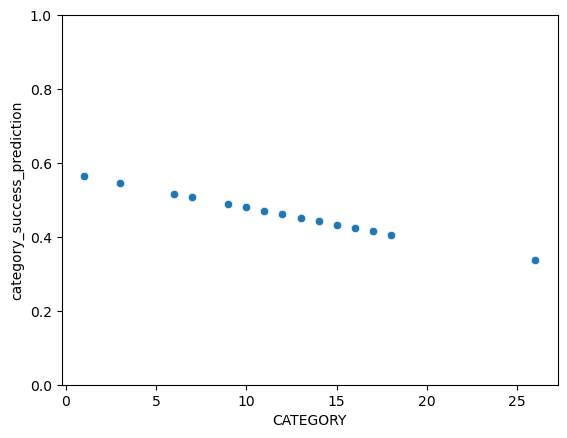

In [42]:
X = pd.DataFrame(clean_data["CATEGORY"])
y = pd.Series(clean_data["STATE"])
category_model = LogisticRegression().fit(X,y)
Category_prediction = category_model.predict_proba(X)
category_success = Category_prediction[:,1]
clean_data["category_success_prediction"] = category_success
sns.scatterplot(clean_data, x = "CATEGORY", y = "category_success_prediction")
plt.ylim(0,1)
plt.show()

downward prediction of category on success - high numbered categories have lower chances of success. *insert key to category labels from pdf*

## Data Limitations

There are several limitations to our research as the data is limited to the Kickerstarter public dataset. Since many variables on our public data tsv are restricted, including the project description, we can’t draw a clear relationship between what exactly about a specific category that leads to it being more or less successful than other categories. This affects the meaning of our results because there are unclear causes that may have a greater impact on how successful a project is. We could only rely on the Category and Subcategory columns for each project.
There may be outside factors such as branding, social media presence, and popularity of the project before it was put on Kickstarter that may affect the success of the project. These confounding variables can skew our results. 


## Questions For Reviewers